Devon Wallerson
8/5/23

This project uses machine learning to predict the house prices in the New
York City metro area. I used publically available datasets from St. Louis
referring to national trends in Home Value, and then actual sales prices
from Zillow.com. 

During this project, I employ data cleaning techniques using Python, and then use SciKit Learn to employ a machine learning model to predict the prices of house value, while being cautious of accuracy.

Thank you for reading!
_________________________________________________________________________


notes -
when importing the file paths, i had trouble, so I had to use the actual file path rather than the file name. Additionally, I had to add r to the front of the path to make sure it was interpreted as a raw path.

1.  import pandas, which helps us work with csv files
2. create a list using the federal dataset names
3. read files in using list comprehension - parse dates, use first column for row indices


In [1]:
import importlib
import pandas as pd


usGov_files = [r"C:\Users\darkn\Downloads\MORTGAGE30US.csv",r"C:\Users\darkn\Downloads\RRVRUSQ156N.csv",r"C:\Users\darkn\Downloads\CPIAUCSL.csv"]

dfs = [pd.read_csv(f, parse_dates = True, index_col = 0) for f in usGov_files]

next, we use the pandas' concatenate function to merge the data sets to one large dataset.

In [2]:
usGov_data = pd.concat(dfs, axis=1)

next, we will apply the assumption that quarterly data withstands throughout the entirety of the quarter. this allows us to eradicate any missing data in our set.

we will employ the forward fill, as we only want to use data that we have at the date 

In [3]:
usGov_data = usGov_data.ffill()

next, we read in the files coming from zillow.com

In [4]:
zillow_files = [r"C:\Users\darkn\Downloads\Metro_median_sale_price_uc_sfrcondo_sm_sa_week.csv", r"C:\Users\darkn\Downloads\Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"]

dfs = [pd.read_csv(f) for f in zillow_files]

now we will reformat the data - focusing solely on the new york, new york region, and removing the first five sections of unecessary data

In [5]:
dfs = [pd.DataFrame(df.iloc[1,5:]) for df in dfs]

now we will add a column to both dataframes so they are merged together. we will do this using a for loop. we will also convert them to a pandas datetime from a string so that we can complete more complex operations. 

to_period function cuts off the date part, and allows us to have a common column that we can join the data frames on 

In [6]:
for df in dfs:
    df.index = pd.to_datetime(df.index)
    df["month"] = df.index.to_period("M")

In [7]:
sales_data = dfs[0].merge(dfs[1], on = "month")

sales_data.index = dfs[0].index

now, we will remove the unecessary month column and assign new names to columns

In [8]:
del sales_data["month"]
sales_data.columns = ["sale price", "home value"]

next, we will merge the zillow price data with the federal data. we will also drop any data that we don't have data for.

we will also use a timedelta to account for the slight difference in the dates reported in the federal dataset and the zillow dataset

In [9]:
usGov_data = usGov_data.dropna()

from datetime import timedelta

usGov_data.index = usGov_data.index + timedelta(days=2)

left index and right index allow python to combine the rows based on the match of the dates between usGovdata and salesdata

In [10]:
sales_data = usGov_data.merge(sales_data, left_index = True, right_index = True)

for the sake of simplicity and cleanliness, we will rename the columns of our dataset

In [11]:
sales_data.columns = ["Interest Rate", "Vacancy Rate", "CPI", "Sale Price", "Home Value"]

now, we will plot our price column. 

in order to plot, we have to install and import importlib

<Axes: >

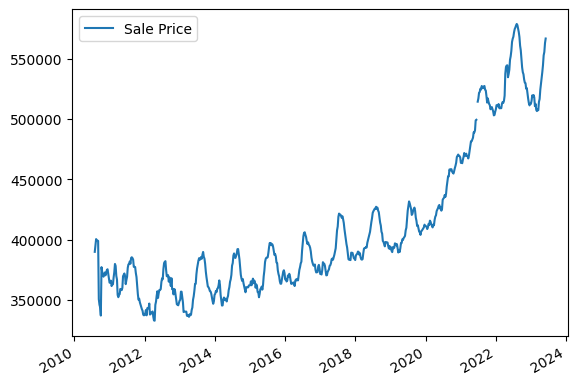

In [12]:
sales_data.plot.line(y="Sale Price", use_index=True)

In order to prevent our model from having to factor in inflation, we can create a new price column that factors in inflation.

In [13]:
sales_data["Adjusted Price"] = sales_data["Sale Price"] / sales_data["CPI"] * 100

<Axes: >

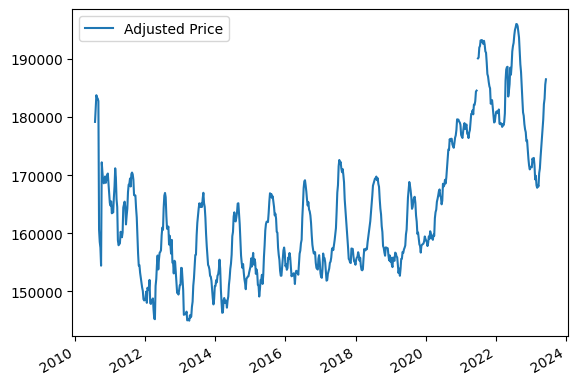

In [14]:
sales_data.plot.line(y="Adjusted Price", use_index=True)

applying the same mentality, we will adjust the house value with the CPI value

In [15]:
sales_data["Adjusted Value"] = sales_data["Home Value"] / sales_data["CPI"] * 100

now, we will set up our target for machine learning. Our target is essentially what we are trying to predict. This model is attmepting to predict what will happen to house values in the next quarter. We will do this with the shift method. This grabs the adjusted price from the future and brings it to the front row. We will use these values to train our algorithm, and the values that are left unfilled will be filled with our model.

The inplace keyowrd allows us to avoid wriitng sales_data = sales_data.dropna()

In [16]:
sales_data["Next Quarter"] = sales_data["Adjusted Price"].shift(-13)

sales_data.dropna(inplace=True)

Change will be our target column that will tell us whether prices went up or down during the quarter.
We will convert our boolean to an integer - if true, = 1. If false, = 0.

In [17]:
sales_data["Change"] = (sales_data["Next Quarter"] > sales_data["Adjusted Price"]).astype(int)

Next, we can use the value counts method to see how many quarters the price raised, and how many times it decreased.

Note- our values are about evenly split, which is good. If it wasn't it would have to be accounted for through the machine learning model.

In [18]:
sales_data["Change"].value_counts()

Change
0    323
1    316
Name: count, dtype: int64

next, we will make a list of predictors, which are variables that will be used to make predictions.

In [19]:
predictors = ["Interest Rate", "Vacancy Rate", "Adjusted Price", "Adjusted Value"]
target = "Change"

at this point, we have completed all of the data cleaning. now, we can begin using the machine learning model. we are using a library called scikit-learn. 

we are importing the RandomForestClassifier, which is a robust model which can pick up nonlinear discrepencies in data.

we are also importing accuracy_score, which will let us know how often our model is correct as a percentage.

lastly, we will import numpy, which is a python library that allows us to more easily work with tables of data.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

first, we will create a prediction function that will take in a training set.

min_samples_split prevents overfitting
random_state helps prevent different results when you run the algorithm two different times by running the model in a randomized state.

In [21]:
def predict (train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split = 10, random_state=1)
    rf.fit(train[predictors], train[target])
    predic = rf.predict(test[predictors])
    return predic

now, we will create a backtesting engine. backtesting uses historical or simulated data to validate the future performance of a model.

we will split our data into train sets , and test sets. training is beforehand, and test is after. 

start is 260 - 5 years worth of data, step - 52 weeks.

we are calling the previous function to create the prediction, and then concatenating it into a single array that has all predictions. then we will return the prediction and the accuracy.

In [22]:
START = 260
STEP = 52

def backtest(data, predictors, target):
    all_predic = []
    for i in range(START, data.shape[0], STEP):
        train = sales_data.iloc[:i]
        test = sales_data.iloc [i: (i+STEP)]
        all_predic.append(predict(train,test,predictors,target))
    predic = np.concatenate(all_predic)
    return predic, accuracy_score(data.iloc[START:][target], predic)

In [23]:
predic, accuracy = backtest(sales_data, predictors, target)

In [24]:
accuracy

0.5171503957783641

this basic model was correct approximately 52% of the time. in order to improve it, we can add a few variables to give the model some more infomration.

year - this will give the model more information about sales prices. we will compare the current interest rate and the average rate within the last year. we use the pandas rolling method, which allows us to process time data.

yearly_ratios - this is the value of the ratio between the current interest rate and the interest rate within the past year.

this gives our model  more information about how the market is trending

In [25]:
year = sales_data.rolling(52,min_periods=1).mean()

yearly_ratios = [p + "_year" for p in predictors]
sales_data [yearly_ratios] = sales_data[predictors] / year[predictors]

In [26]:
preds, accuracy = backtest(sales_data, predictors + yearly_ratios, target)

In [27]:
accuracy

0.5329815303430079

this has slightly improved the accuracy of our model. now, i will plot to see where the model is making mistakes.

In [28]:
pred_match = (predic == sales_data[target].iloc[START:])

In [29]:
pred_match[pred_match == True] = "green"
pred_match[pred_match == False] = "red"

<Axes: xlabel='index', ylabel='Adjusted Value'>

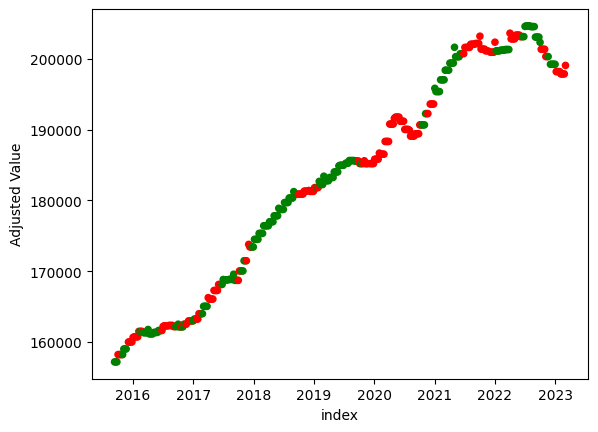

In [30]:
import matplotlib.pyplot as plt

plot_data = sales_data.iloc[START:].copy()
plot_data.reset_index().plot.scatter(x="index", y="Adjusted Value", color=pred_match)

here, we can see that the model struggles when the market begins to shift, especially during the early COVID pandemic

in order to improve our model, we are now checking to see which columns are the most important.

In [31]:
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(min_samples_split=10, random_state=1)
rf.fit(sales_data[predictors], sales_data[target])

result = permutation_importance(rf, sales_data[predictors], sales_data[target], n_repeats=10, random_state=1)

In [32]:
result["importances_mean"]

array([0.12347418, 0.16197183, 0.29780908, 0.23223787])

from here, we can add more information to our model to help improve its accuracy, or use a different machine learning method to improve the accuracy of this model.